# **DISTIL Usage Example: MedMNIST**

Here, we show how to use DISTIL to perform active learning on image classification tasks (MedMNIST's OrganAMNIST). This notebook can be easily executed on Google Colab. ([Source](https://github.com/decile-team/distil/blob/main/tutorials/image_classification/DISTIL_Example_MedMNIST.ipynb))

## Installation and Imports

In [7]:
# Get DISTIL
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch.optim as optim
import torch.nn.functional as F
sys.path.append("MedMNIST/")
from medmnist import OrganAMNIST
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, Subset, ConcatDataset, DataLoader
from torchvision import transforms
from torchvision.datasets import cifar
from distil.active_learning_strategies import GLISTER, BADGE, EntropySampling, RandomSampling, ASCG   # All active learning strategies showcased in this example
from distil.utils.models.resnet import ResNet18                                                 # The model used in our image classification example
from distil.utils.train_helper import data_train                                                # A utility training class provided by DISTIL
from distil.utils.utils import LabeledToUnlabeledDataset                                        # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Preparing OrganAMNIST

The MedMNIST dataset OrganAMNIST contains 58,850 28x28 monochrome images (34,581 train, 6,491 validation, 17,778 test) in 11 different classes. The 11 different classes represent 11 different organs, and the task is to correctly classify a given axial view of an organ. Here, we do a simple setup of the OrganAMNIST dataset that we will use in this example. More importantly, we define a split on OrganAMNIST's training set into an initial labeled seed set and an unlabeled set.

**Calculate Average/STD**

In [2]:
# We do not have the average and standard deviation to use for data normalization. Here, we compute 
# it on a per-pixel basis, and we use the training set only for this calculation.

train_dataset = OrganAMNIST(root=".", split="train", download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

average = 0.
num_pixels = 0
for batch_idx, (image, label) in enumerate(train_dataloader):
    image = image.to("cuda")
    average += image.sum()
    num_pixels += len(image.flatten())
average = average.item() / num_pixels

var = 0.
for batch_idx, (image, label) in enumerate(train_dataloader):
    image = image.to("cuda").flatten()
    image_diff = image - average
    image_var = torch.dot(image_diff, image_diff)
    var += image_var

std = math.sqrt(var / (num_pixels - 1))

print("AVERAGE:",average)
print("STD:",std)

38248448it [01:18, 487780.14it/s]                              


AVERAGE: 0.4677578197063505
STD: 0.2975477576591013


**Create OrganAMNIST Dataset**

In [3]:
data_set_name = 'OrganAMNIST'
download_path = '.'

# Define transforms on the dataset splits of OrganAMNIST. Here, we use random crops and horizontal flips for training augmentations.
# Both the train and test sets are converted to PyTorch tensors and are normalized around the mean/std of OrganAMNIST.
organ_amnist_training_transform = transforms.Compose([transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((average,), (std,))])
organ_amnist_test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((average,), (std,))])

# OrganAMNIST provides its labels in list form; so we need to get the original label
target_transform = lambda x: x[0]

# Get the dataset objects from MedMNIST. Here, OrganAMNIST is downloaded, and the transform is applied when points 
# are retrieved.
organ_amnist_full_train = OrganAMNIST(root=download_path, split="train", download=True, transform=organ_amnist_training_transform, target_transform=target_transform)
organ_amnist_test = OrganAMNIST(root=download_path, split="test", download=True, transform=organ_amnist_test_transform, target_transform=target_transform)

# Get the dimension of the images. Here, we simply take the very first image of OrganAMNIST
# and query its dimension.
dim = np.shape(organ_amnist_full_train[0][0])

# We now define a train-unlabeled split for the sake of the experiment. Here, we simply take 250 points as the initial seed set.
# The rest of the points are taken as the unlabeled set. While the unlabeled set constructed here technically has labels, they 
# are only used when querying for labels. Hence, they only exist here for the sake of experimental design.
train_size = 250
organ_amnist_train = Subset(organ_amnist_full_train, list(range(train_size)))
organ_amnist_unlabeled = Subset(organ_amnist_full_train, list(range(train_size, len(organ_amnist_full_train))))

# Define the number of active learning rounds to conduct, the budget, and the number of classes in OrganAMNIST
nclasses = 11
n_rounds = 7
budget = 250

Using downloaded and verified file: ./organamnist.npz
Using downloaded and verified file: ./organamnist.npz


## Preparing the Model

Here, we use DISTIL's provided implementation of the [ResNet-18](https://arxiv.org/abs/1512.03385) architecture. We also create a model directory to store trained models in this example.

In [4]:
net = ResNet18(num_classes=nclasses, channels=1)
base_dir = "models"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')

## Training an Initial Model
Here, we train an initial model. We do so by creating a training loop object on the initial seed set, the model architecture, and a list of provided arguments. We then save the initial model. Note: If you've already run the first cell, then you can simply run the second cell.

In [5]:
# Specify additional training parameters. Here, we set the maximum number of epochs of training to 300, 
# the learning rate to 0.01, the batch size to 20, the maximum train accuracy of training to 0.99, and 
# the optimizer to stochastic gradient descent.
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd', 'device':'cuda:1'} 
dt = data_train(organ_amnist_train, net, args)
clf = dt.train()
torch.save(clf.state_dict(), model_directory)

Training..
Epoch: 88 Training accuracy: 0.992


In [6]:
base_dir = "models"
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

## Active Learning Strategies

Here, we show examples of a couple active learning strategies being used in the setting of image classification.

### Random Sampling
This strategy is often used as a baseline, where we pick a subset of unlabeled points randomly. Here, we create a instance of `distil.active_learning_strategies.random_sampling.RandomSampling` by passing following parameters:

**training_dataset** – The labeled dataset, which has a PyTorch interface that returns a tensor of data and a tensor of labels OR a dictionary with a "labels" key.

**unlabeled_dataset** – The unlabeled dataset, which has a PyTorch interface that returns a tensor of data OR a dictionary.

**net** – Model architecture used for training. Could be instance of models defined in distil.utils.models or something similar (in this instance, a Huggingface transformer).

**nclasses** – No. of classes in the dataset

**args**– This dictionary should have ‘batch_size’ as a key. 'batch_size' should be such that one can exploit the benefits of tensorization while honouring the resourse constraits. This ‘batch_size’ therefore can be different than the one used for training.


In [8]:
# Initialize the random sampling AL strategy. Note: The labels are shaved off the unlabeled dataset above to match the setting.
strategy_args = {'batch_size' : 20, 'device':'cuda:1'}
strategy = RandomSampling(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled), net, nclasses, strategy_args)

# Use the same training parameters as before
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd', 'device':'cuda:1'} 
dt = data_train(organ_amnist_train, clf, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(clf)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(organ_amnist_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    organ_amnist_full_train.transform = organ_amnist_test_transform       # Disable augmentation while selecting new points as to not interfere with the strategies
    idx = strategy.select(budget)
    organ_amnist_full_train.transform = organ_amnist_training_transform   # Enable augmentation

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    organ_amnist_train = ConcatDataset([organ_amnist_train, Subset(organ_amnist_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(organ_amnist_unlabeled))) - set(idx))
    organ_amnist_unlabeled = Subset(organ_amnist_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(organ_amnist_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled))
    dt.update_data(organ_amnist_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(organ_amnist_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

# Lastly, we save the accuracies in case a comparison is warranted.
with open(os.path.join(base_dir,'random_medmnist.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 78.54
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 500
Training..
Epoch: 96 Training accuracy: 0.994
Testing accuracy: 83.52
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 750
Training..
Epoch: 88 Training accuracy: 0.993
Testing accuracy: 85.98
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1000
Training..
Epoch: 78 Training accuracy: 0.99
Testing accuracy: 85.89
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1250
Training..
Epoch: 86 Training accuracy: 0.991
Testing accuracy: 85.26
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training 

### ASCG
A very basic strategy to select unlabeled points using submodular conditional gain functions. 

Here, we create a instance of `distil.active_learning_strategies.ascg.ASCG` with the same parameters passed to `distil.active_learning_strategies.random_sampling.RandomSampling`.

**Reloading Base Model & Data**

We make sure the fixture is the same by repeating the same setup.

In [ ]:
data_set_name = 'OrganAMNIST'
download_path = '.'

# Define transforms on the dataset splits of OrganAMNIST. Here, we use random crops and horizontal flips for training augmentations.
# Both the train and test sets are converted to PyTorch tensors and are normalized around the mean/std of OrganAMNIST.
organ_amnist_training_transform = transforms.Compose([transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((average,), (std,))])
organ_amnist_test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((average,), (std,))])

# OrganAMNIST provides its labels in list form; so we need to get the original label
target_transform = lambda x: x[0]

# Get the dataset objects from MedMNIST. Here, OrganAMNIST is downloaded, and the transform is applied when points 
# are retrieved.
organ_amnist_full_train = OrganAMNIST(root=download_path, split="train", download=True, transform=organ_amnist_training_transform, target_transform=target_transform)
organ_amnist_test = OrganAMNIST(root=download_path, split="test", download=True, transform=organ_amnist_test_transform, target_transform=target_transform)

# Get the dimension of the images. Here, we simply take the very first image of OrganAMNIST
# and query its dimension.
dim = np.shape(organ_amnist_full_train[0][0])

# We now define a train-unlabeled split for the sake of the experiment. Here, we simply take 1000 points as the initial seed set.
# The rest of the points are taken as the unlabeled set. While the unlabeled set constructed here technically has labels, they 
# are only used when querying for labels. Hence, they only exist here for the sake of experimental design.
train_size = 250
organ_amnist_train = Subset(organ_amnist_full_train, list(range(train_size)))
organ_amnist_unlabeled = Subset(organ_amnist_full_train, list(range(train_size, len(organ_amnist_full_train))))

# Define the number of active learning rounds to conduct, the budget, and the number of classes in OrganAMNIST
nclasses = 11
n_rounds = 7
budget = 250

In [ ]:
net = ResNet18(num_classes=nclasses, channels=1)
base_dir = "models"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')

In [ ]:
base_dir = "models"
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

In [ ]:
# Initialize the random sampling AL strategy. Note: The labels are shaved off the unlabeled dataset above to match the setting.
strategy_args = {'batch_size' : 20, 'device':'cuda:1', 'scg_function': 'flcg'}
strategy = ASCG(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled), net, nclasses, strategy_args)

# Use the same training parameters as before
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd', 'device':'cuda:1'} 
dt = data_train(organ_amnist_train, clf, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(clf)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(organ_amnist_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    organ_amnist_full_train.transform = organ_amnist_test_transform       # Disable augmentation while selecting new points as to not interfere with the strategies
    idx = strategy.select(budget)
    organ_amnist_full_train.transform = organ_amnist_training_transform   # Enable augmentation

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    organ_amnist_train = ConcatDataset([organ_amnist_train, Subset(organ_amnist_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(organ_amnist_unlabeled))) - set(idx))
    organ_amnist_unlabeled = Subset(organ_amnist_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(organ_amnist_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled))
    dt.update_data(organ_amnist_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(organ_amnist_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

# Lastly, we save the accuracies in case a comparison is warranted.
with open(os.path.join(base_dir,'ascg_medmnist.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

### Entropy Sampling
A very basic strategy to select unlabeled points is entropy sampling, where we select samples about which the model is most uncertain by measuring the entropy of the class prediction. Hence, a valid strategy is to select those points in the unlabeled set with highest entropy (maximum uncertainty). Specifically, let $z = f(x)$ be the output from the model with class $i$ having score $z_i$. By applying a softmax, we obtain probabilities that we can use: 

$$\sigma(z)_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$$ 

Using the softmax probabilities, entropy sampling selects a subset based on the following objective:

 $$\text{argmin}_{A \subseteq U, |A| = k} \sum_{x \in A} \left[ -\sum_j \sigma(z)_j*\log(\sigma(z)_j) \right]$$

Here, we create a instance of `distil.active_learning_strategies.entropy_sampling.EntropySampling` with the same parameters passed to `distil.active_learning_strategies.random_sampling.RandomSampling`.

**Reloading Base Model & Data**

We make sure the fixture is the same by repeating the same setup.

In [ ]:
data_set_name = 'OrganAMNIST'
download_path = '.'

# Define transforms on the dataset splits of OrganAMNIST. Here, we use random crops and horizontal flips for training augmentations.
# Both the train and test sets are converted to PyTorch tensors and are normalized around the mean/std of OrganAMNIST.
organ_amnist_training_transform = transforms.Compose([transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((average,), (std,))])
organ_amnist_test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((average,), (std,))])

# OrganAMNIST provides its labels in list form; so we need to get the original label
target_transform = lambda x: x[0]

# Get the dataset objects from MedMNIST. Here, OrganAMNIST is downloaded, and the transform is applied when points 
# are retrieved.
organ_amnist_full_train = OrganAMNIST(root=download_path, split="train", download=True, transform=organ_amnist_training_transform, target_transform=target_transform)
organ_amnist_test = OrganAMNIST(root=download_path, split="test", download=True, transform=organ_amnist_test_transform, target_transform=target_transform)

# Get the dimension of the images. Here, we simply take the very first image of OrganAMNIST
# and query its dimension.
dim = np.shape(organ_amnist_full_train[0][0])

# We now define a train-unlabeled split for the sake of the experiment. Here, we simply take 1000 points as the initial seed set.
# The rest of the points are taken as the unlabeled set. While the unlabeled set constructed here technically has labels, they 
# are only used when querying for labels. Hence, they only exist here for the sake of experimental design.
train_size = 250
organ_amnist_train = Subset(organ_amnist_full_train, list(range(train_size)))
organ_amnist_unlabeled = Subset(organ_amnist_full_train, list(range(train_size, len(organ_amnist_full_train))))

# Define the number of active learning rounds to conduct, the budget, and the number of classes in OrganAMNIST
nclasses = 11
n_rounds = 7
budget = 250

Using downloaded and verified file: ./organamnist.npz
Using downloaded and verified file: ./organamnist.npz


In [ ]:
net = ResNet18(num_classes=nclasses, channels=1)
base_dir = "models"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')

In [ ]:
base_dir = "models"
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

In [ ]:
# Initialize the random sampling AL strategy. Note: The labels are shaved off the unlabeled dataset above to match the setting.
strategy_args = {'batch_size' : 20, 'device':'cuda:1'}
strategy = EntropySampling(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled), net, nclasses, strategy_args)

# Use the same training parameters as before
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd', 'device':'cuda:1'} 
dt = data_train(organ_amnist_train, clf, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(clf)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(organ_amnist_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    organ_amnist_full_train.transform = organ_amnist_test_transform       # Disable augmentation while selecting new points as to not interfere with the strategies
    idx = strategy.select(budget)
    organ_amnist_full_train.transform = organ_amnist_training_transform   # Enable augmentation

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    organ_amnist_train = ConcatDataset([organ_amnist_train, Subset(organ_amnist_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(organ_amnist_unlabeled))) - set(idx))
    organ_amnist_unlabeled = Subset(organ_amnist_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(organ_amnist_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled))
    dt.update_data(organ_amnist_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(organ_amnist_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

# Lastly, we save the accuracies in case a comparison is warranted.
with open(os.path.join(base_dir,'entropy_medmnist.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 75.22
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 500
Training..
Epoch: 93 Training accuracy: 0.99
Testing accuracy: 84.6
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 750
Training..
Epoch: 117 Training accuracy: 0.993
Testing accuracy: 87.79
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1000
Training..
Epoch: 106 Training accuracy: 0.991
Testing accuracy: 87.28
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1250
Training..
Epoch: 114 Training accuracy: 0.998
Testing accuracy: 89.94
-------------------------------------------------
Round 5
-------------------------------------------------
Number of trainin

### BADGE
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). The strategy is meant to select points that are both diverse (e.g., their embeddings span multiple directions) and uncertain (e.g., their contribution to the loss is large). The following steps are taken:

* Calculate the pseudo-label for each point in the unlabeled set. The pseudo-label is the class with the highest probability.
* Compute the cross-entropy loss for each point in the unlabeled set using this pseudo-label.
* Obtain the resulting loss gradients on the last linear layer of the model for each point. (These are referred to as the hypothesized loss gradients.)
* Using these gradients as a form of embedding for each unlabeled point, run k-means++ initialization on this embedding set, retrieving $k$ centers. Each center is a point from the unlabeled set, and $k$ represents the active learning budget.
* Request labels for the $k$ points whose embeddings were selected.

Here we create a instance of `distil.active_learning_strategies.badge.BADGE` with same parameters passed to `distil.active_learning_strategies.random_sampling.RandomSampling`.

**Reloading Base Model & Data**

In [ ]:
data_set_name = 'OrganAMNIST'
download_path = '.'

# Define transforms on the dataset splits of OrganAMNIST. Here, we use random crops and horizontal flips for training augmentations.
# Both the train and test sets are converted to PyTorch tensors and are normalized around the mean/std of OrganAMNIST.
organ_amnist_training_transform = transforms.Compose([transforms.RandomCrop(28, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((average,), (std,))])
organ_amnist_test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((average,), (std,))])

# OrganAMNIST provides its labels in list form; so we need to get the original label
target_transform = lambda x: x[0]

# Get the dataset objects from MedMNIST. Here, OrganAMNIST is downloaded, and the transform is applied when points 
# are retrieved.
organ_amnist_full_train = OrganAMNIST(root=download_path, split="train", download=True, transform=organ_amnist_training_transform, target_transform=target_transform)
organ_amnist_test = OrganAMNIST(root=download_path, split="test", download=True, transform=organ_amnist_test_transform, target_transform=target_transform)

# Get the dimension of the images. Here, we simply take the very first image of OrganAMNIST
# and query its dimension.
dim = np.shape(organ_amnist_full_train[0][0])

# We now define a train-unlabeled split for the sake of the experiment. Here, we simply take 1000 points as the initial seed set.
# The rest of the points are taken as the unlabeled set. While the unlabeled set constructed here technically has labels, they 
# are only used when querying for labels. Hence, they only exist here for the sake of experimental design.
train_size = 250
organ_amnist_train = Subset(organ_amnist_full_train, list(range(train_size)))
organ_amnist_unlabeled = Subset(organ_amnist_full_train, list(range(train_size, len(organ_amnist_full_train))))

# Define the number of active learning rounds to conduct, the budget, and the number of classes in OrganAMNIST
nclasses = 11
n_rounds = 7
budget = 250

Using downloaded and verified file: ./organamnist.npz
Using downloaded and verified file: ./organamnist.npz


In [ ]:
net = ResNet18(num_classes=nclasses, channels=1)
base_dir = "models"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')

In [ ]:
base_dir = "models"
model_directory = os.path.join(base_dir, 'base_medmnist_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

In [ ]:
# Initialize the random sampling AL strategy. Note: The labels are shaved off the unlabeled dataset above to match the setting.
strategy_args = {'batch_size' : 20, 'device':'cuda:1'}
strategy = BADGE(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled), net, nclasses, strategy_args)

# Use the same training parameters as before
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd', 'device':'cuda:1'} 
dt = data_train(organ_amnist_train, clf, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(clf)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(organ_amnist_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    organ_amnist_full_train.transform = organ_amnist_test_transform       # Disable augmentation while selecting new points as to not interfere with the strategies
    idx = strategy.select(budget)
    organ_amnist_full_train.transform = organ_amnist_training_transform   # Enable augmentation

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    organ_amnist_train = ConcatDataset([organ_amnist_train, Subset(organ_amnist_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(organ_amnist_unlabeled))) - set(idx))
    organ_amnist_unlabeled = Subset(organ_amnist_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(organ_amnist_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(organ_amnist_train, LabeledToUnlabeledDataset(organ_amnist_unlabeled))
    dt.update_data(organ_amnist_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(organ_amnist_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

# Lastly, we save the accuracies in case a comparison is warranted.
with open(os.path.join(base_dir,'badge_medmnist.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 75.22
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 500
Training..
Epoch: 86 Training accuracy: 0.992
Testing accuracy: 87.31
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 750
Training..
Epoch: 117 Training accuracy: 0.995
Testing accuracy: 87.83
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1000
Training..
Epoch: 102 Training accuracy: 0.991
Testing accuracy: 89.82
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1250
Training..
Epoch: 123 Training accuracy: 0.992
Testing accuracy: 90.95
-------------------------------------------------
Round 5
-------------------------------------------------
Number of train

## Visualizing the Results

If all strategies have run to completion, you can run the following cell to view the results.

Text(0.5, 1.0, 'DISTIL_OrganAMNIST')

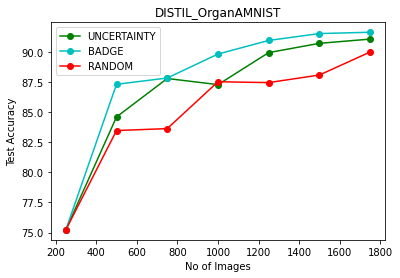

In [ ]:
# Load the accuracies previously obtained
with open(os.path.join(base_dir,'entropy_medmnist.txt'), 'r') as f:
  acc_ = f.readlines()
acc_en = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'badge_medmnist.txt'), 'r') as f:
  acc_ = f.readlines()
acc_bd = [round(float(x)*100, 2) for x in acc_]
# with open(os.path.join(base_dir,'glister.txt'), 'r') as f:
#   acc_ = f.readlines()
# acc_gl = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'random_medmnist.txt'), 'r') as f:
  acc_ = f.readlines()
acc_rd = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'ascg_medmnist.txt'), 'r') as f:
  acc_ = f.readlines()
acc_ascg = [round(float(x)*100, 2) for x in acc_]
# Plot them using matplotlib
x_axis = np.array([train_size+budget*i for i in range(n_rounds)])
plt.figure()
# plt.plot(x_axis, acc_gl, 'b-', label='GLISTER RAND',marker='o')
plt.plot(x_axis, acc_en, 'g-', label='UNCERTAINITY',marker='o')
plt.plot(x_axis, acc_bd, 'c', label='BADGE',marker='o')
plt.plot(x_axis, acc_rd, 'r', label='RANDOM',marker='o')
plt.plot(x_axis, acc_ascg, 'y', label='ASCG',marker='o')

plt.legend()
plt.xlabel('No of Images')
plt.ylabel('Test Accuracy')
plt.title('DISTIL_CIFAR10')